# VISUALS
Some visuals we can create using the data. 
## TODO:
* ~~Sanitize inputs (e.g. remove Pro Bowl and All-Pro designation symbols)~~
    ~~* Sanitize inputs by ignoring non-qualifiers (e.g. receivers who have <20 recs)~~
* ~~Calculate difference of QB's stats after we remove stats from their top receiver~~
    * ~~Calculate average difference in yds, TDs, rtg, etc.~~
    * ~~Create df that contains difference after removing top receiver stats~~
* Visiualize differences of QB's stats with and without top receiver
* ~~Use data only for QB's who qualify (e.g. >= 300 atts in a season)~~
* Use data only for receivers who qualify (e.g. top 2/3 leaders in receptions per team)
    * How can we use JOIN to extract this data?
        * How can we then JOIN this data with QB's team?
            * In retrospect I should've just made dataframes in SQL that JOINed the data instead of
              joining it here but too late
* ~~Create table/dataframe showing every QB and their top receiver (and their receiver's stats)~~
     
## Code Organization:
* I frequently use the same codes to check, reset, and set a dataframe's indices in a function. This could be its own function.
* Remove other repetitive and unused code chunks, as well as find ways to make code more concise in general.
* Create function that generates table

# Setting Up
Import packages, CSVs, and other configurations necessary for the project.

In [621]:
# IMPORTS
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3 as sql
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statistics import mean

In [622]:
# Configurations
pd.set_option('display.max_columns', None)


In [623]:
# Get CSVs and store them in a dictionary
advPassAir = {}
advPassAccuracy = {}
passing = {}
rec = {}
advRec = {}
topRec = {}
top3rec = {}
advTopRec = {}

years = [18, 19, 20, 21, 22, 23]
for x in years:
    advPassAir[x] = pd.read_csv('Data/passing/advPassAir' + str(x) + '.csv')
    advPassAccuracy[x] = pd.read_csv('Data/passing/advPassAccuracy' + str(x) + '.csv')
    passing[x] = pd.read_csv('Data/passing/pass' + str(x) + '.csv')
    rec[x] = pd.read_csv('Data/receiving/rec' + str(x) + '.csv')
    advRec[x] = pd.read_csv('Data/receiving/advRec' + str(x) + '.csv')
    topRec[x] = pd.read_csv('Data/receiving/topRec' + str(x) + '.csv')
    top3rec[x] = pd.read_csv('Data/receiving/top3rec' + str(x) + '.csv')
    advTopRec[x] = pd.read_csv('Data/receiving/advTopRec' + str(x) + '.csv')


print(passing)
print(advPassAir[18].head())
print(advPassAccuracy[18].head())
print(advRec[18].head())


{18:      Unnamed: 0   Rk              Player   Tm Age Pos   G  GS   QBrec  Cmp  \
0             0    1  Ben Roethlisberger  PIT  36  QB  16  16   9-6-1  452   
1             1    2   Patrick Mahomes*+  KAN  23  QB  16  16  12-4-0  383   
2             2    3           Matt Ryan  ATL  33  QB  16  16   7-9-0  422   
3             3    4         Jared Goff*  LAR  24  QB  16  16  13-3-0  364   
4             4    5        Andrew Luck*  IND  29  QB  16  16  10-6-0  430   
..          ...  ...                 ...  ...  ..  ..  ..  ..     ...  ...   
104         104  102   DeAndre Hopkins*+  HOU  26  WR  16  16     NaN    0   
105         105  103           Zay Jones  BUF  23  WR  16  15     NaN    0   
106         106  104       Kyle Lauletta  NYG  23  QB   2   0     NaN    0   
107         107  105            JK Scott  GNB  23   P  16   0     NaN    0   
108         108  106      Dede Westbrook  JAX  25  WR  16   9     NaN    0   

     Att  Cmp%   Yds  TD  TD% Int  Int%   1D Succ% Lng  Y/

In [624]:
# Preliminary data sanitization

# Delete rows with no numeric values in passing data

'''
Profoobtallreference likes to repeat the row of features within the csv several times, 
however this row is treated like a normal value within the dataframe. This loop will see that if 
a row's value shares the same name as its column (e.g. a row's 'Att' value is literally 'Att'),
then we will drop the row.
'''

for x in years:
    df_drop = passing[x]
    index_to_drop = df_drop[df_drop['Att'] == 'Att'].index
    passing[x].drop(index_to_drop, inplace = True)
    passing[x].reset_index(drop=True, inplace=True)

# We need to actually convert the numeric columns from string to int/float
for x in years:
    passing[x]['Cmp'] = passing[x]['Cmp'].astype(int)
    passing[x]['Att']=  passing[x]['Att'].astype(int)
    passing[x]['GS'] = passing[x]['GS'].astype(int)
    passing[x]['Yds'] = passing[x]['Yds'].astype(int)
    passing[x]['TD'] = passing[x]['TD'].astype(int)
    passing[x]['Int'] = passing[x]['Int'].astype(int)
    passing[x]['Cmp%'] = passing[x]['Cmp%'].astype(float)
    passing[x]['Rate'] = passing[x]['Rate'].astype(float)
    

# HELPER FUNCTIONS

Helper functions used for sanitizing data, creating new dataframes to find differences, etc.

In [625]:
# Helper Functions

def QBqualifers(df, qual = 'Att', val = 300):
    df_qual = df[df[qual] >= val]
    df_qual.reset_index(drop = True, inplace = True)
    return df_qual

# Problem with iterating through all rows is it deletes players completely,
# which therefore deletes the index. So if it drops row 29, if I attempt to access
# index 29, it will return an error as index 29 DNE.
def sanitize(df):
    # Sanitize names by deleting symbols
    length = df.shape[0]
    for i in range(length):
        name = df.loc[i]['Player']
        new_name = re.sub("[*+]", "", name)
        df.at[i, 'Player'] = new_name

    # Remove any and all duplicates
    df = df.drop_duplicates(subset=['Tm'], keep='first')

# NFL passer rating formula does not allow each variable (i.e. a, b, c. d)
# to be above 2.375. See details here: https://en.wikipedia.org/wiki/Passer_rating
def checkPsrRtgVar(x):
    if x > 2.375:
        return 2.375
    if x < 0:
        return 0

# Official NFL Passer Rating formula
def psrRtg(cmp, att, yds, td, int):
    a = ((cmp/att) - 0.3) * 5
    b = ((yds/att) - 3) * 0.25
    c = (td/att) * 20
    d = 2.375 - ((int/att) * 25)

    variables = [a, b, c, d]
    
    # Each "variable" is actually a list containing the respective value for all teams 
    # (e.g. a contains the calculation of a for all 32 teams), hence the need for a double for loop
    for x in variables:
        for i in x:
            checkPsrRtgVar(i)
    a, b, c, d = variables
    
    rtg = (a + b + c + d)/6
    return round((rtg * 100), 1)

In [626]:
# Function that finds top receiver for qualified QBs (i.e. drops irrelevant top receivers from dataframe)

def sharedRec(dfQB, dfRec):
    # First, reset indices if needed
    if dfQB.index.name == 'Tm':
        dfQB.reset_index('Tm', inplace = True)
    if dfRec.index.name == 'Tm':
        dfRec.reset_index('Tm', inplace = True)

    # Sort by team
    dfQB = dfQB.sort_values(by='Tm')
    dfRec = dfRec.sort_values(by='Tm')


    # Ensure stats are subtracted based on same index (i.e. team)
    # Only account for receivers for qualifying QBs
    dfRec_shared = dfRec[dfRec['Tm'].isin(dfQB['Tm'])]

    # Create new column of top receiver's corresponding QB
    if 'Tm' in dfRec_shared.columns and 'Tm' in dfQB.columns:
    # Filter dfQB for rows where 'Tm' is in dfRec_shared['Tm'], then select 'Player' column
        players = dfQB.loc[dfQB['Tm'].isin(dfRec_shared['Tm']), 'Player']

    # Assign the selected players to dfRec_shared['QB']
    dfRec_shared['QB'] = players.values

    # Add a column with completion percentage
    dfRec_shared['Cmp%'] = round((dfRec_shared['Rec']/dfRec_shared['Tgt'])*100, 1)
    
    return dfRec_shared

In [627]:

# Function that creates new dataframe that subtracts QB's stats after removing stats from top receiver
# dfQB is the dataframe of QBs whose stats need to be subtracted, dfRec is the dataframe of receivers 
def subtractQBstats(dfQB, dfRec):
    # First, reset indices if needed
    if dfQB.index.name == 'Tm':
        dfQB.reset_index('Tm', inplace = True)
    if dfRec.index.name == 'Tm':
        dfRec.reset_index('Tm', inplace = True)
    
    # Sort by team
    dfQB = dfQB.sort_values(by='Tm')
    dfRec = dfRec.sort_values(by='Tm')
    
    # Ensure stats are subtracted based on same index (i.e. team)
    # Only account for receivers for qualifying QBs
    dfRec_shared = dfRec[dfRec['Tm'].isin(dfQB['Tm'])]

    # Now set indices, but first obtain list of shared teams
    tms = dfQB['Tm']
    dfQB.set_index('Tm', inplace = True)
    dfRec_shared.set_index('Tm', inplace = True)
    
    # Subtract stats
    stats_to_sub = ['Yds', 'TD', 'Int']
    cmp_sub = dfQB['Cmp'] - dfRec_shared['Rec'] # Assume receptions are analogous to completions
    att_sub = dfQB['Att'] - dfRec_shared['Tgt'] # Assume targets are analogous to attempts
    
    # Create new df of QB data with stats subtracted 
    dfQB_sub = dfQB[stats_to_sub] - dfRec_shared[stats_to_sub]
    dfQB_sub.insert(0, 'Cmp%', round((cmp_sub/att_sub)*100, 1)) # Add in new cmp%
    dfQB_sub.insert(0, 'Cmp', cmp_sub)
    dfQB_sub.insert(0, 'Att', att_sub)
    dfQB_sub.insert(len(dfQB_sub.columns), 'Rate', psrRtg(cmp_sub, att_sub, dfQB_sub['Yds'], dfQB_sub['TD'], dfQB_sub['Int']))
    dfQB_sub.insert(0, 'Player', dfQB['Player'])
    
    # Reset indices again, including for dfQB_sub
    dfQB.reset_index('Tm', inplace = True)
    dfQB_sub.reset_index('Tm', inplace = True)

    return(dfQB_sub)

In [628]:
# TODO: For now, assume indices ARE reset

# Checks to see if difference in QB stats adds up correctly
# Original QB df, QB df after subtractions, original Rec df, and stat to check are respective parameters
# NOTE: This won't work for psrRtg as it is not a volume stat and needs to be recalculated completely

def checker(dfQB, dfQBdiff, dfRec, stat = 'Yds'):
    # First, reset indices if needed
    if dfQB.index.name == 'Tm':
        dfQB.reset_index('Tm', inplace = True)
    if dfRec.index.name == 'Tm':
        dfRec.reset_index('Tm', inplace = True)
    if dfQBdiff.index.name == 'Tm':
        dfQBdiff.reset.index('Tm', inplace = True)
    
    # Sort indices, notice how the naming is now camel case instead of snake case. 
    # This is intentional as I don't want to modify original df. 
    # I think this creates a copy at least.
    df_QB = dfQB.sort_values(by='Tm')
    df_QBdiff = dfQBdiff.sort_values(by='Tm')
    df_rec = dfRec.sort_values(by='Tm')

    # Remove any non-qualified QBs
    df_QB = df_QB[df_QB['Tm'].isin(df_QBdiff['Tm'])]
    df_rec = df_rec[df_rec['Tm'].isin(df_QBdiff['Tm'])]

    # Set indices
    df_QB.set_index('Tm', inplace = True)
    df_QBdiff.set_index('Tm', inplace = True)
    df_rec.set_index('Tm', inplace = True)

    for i in df_QB.index:
        if df_QBdiff.loc[i][stat] + df_rec.loc[i][stat] != df_QB.loc[i][stat]:
            return ("Discrepancy at " + i)
    return True



In [629]:
# TODO: Also would be nice to find a way to get averages in stats lost (this could be a separate function)
# TODO: Create dataframe of distance in stats QB lost? (e.g. did Tua how many more/less yards did Tua lose compared to average)?

# Returns dictionary of average loss in stats
# Original QB df, QB df after subtractions, and name of dictionary, are respective parameters
def avgLoss(dfQB, dfQBdiff):
    # First, reset indices if needed
    # TODO: Make checks and sorts below its own function?
    if dfQB.index.name == 'Tm':
        dfQB.reset_index('Tm', inplace = True)
    if dfQBdiff.index.name == 'Tm':
        dfQBdiff.reset.index('Tm', inplace = True)

    # Sort indices, notice how the naming is now camel case instead of snake case. 
    # This is intentional as I don't want to modify original df. 
    # I think this creates a copy at least.
    df_QB = dfQB.sort_values(by='Tm')
    df_QBdiff = dfQBdiff.sort_values(by='Tm')

    # Remove any non-qualified QBs
    df_QB = df_QB[df_QB['Tm'].isin(df_QBdiff['Tm'])]

    # Set indices
    df_QB.set_index('Tm', inplace = True)
    df_QBdiff.set_index('Tm', inplace = True)

    for i in df_QB.index:
        # Is there a more efficient way to do this?
        att = (df_QB.loc[i]['Att'] - df_QBdiff.loc[i]['Att']).mean()
        cmp = (df_QB.loc[i]['Cmp'] - df_QBdiff.loc[i]['Cmp']).mean()
        cmp_per = round((round(((df_QB.loc[i]['Cmp'] - cmp)/(df_QB.loc[i]['Att'] - att)*100), 1) \
        - round(((df_QBdiff.loc[i]['Cmp'] - cmp)/(df_QBdiff.loc[i]['Att'] - att)*100), 1)).mean(), 1)
        yds = (df_QB.loc[i]['Yds'] - df_QBdiff.loc[i]['Yds']).mean()
        td = (df_QB.loc[i]['TD'] - df_QBdiff.loc[i]['TD']).mean()
        int = (df_QB.loc[i]['Int'] - df_QBdiff.loc[i]['Int']).mean()
        rate = round((df_QB.loc[i]['Rate'] - df_QBdiff.loc[i]['Rate']).mean(), 1)
        
    statLoss = {
        'Att': att,
        'Cmp': cmp,
        'Cmp%': cmp_per,
        'Yds': yds,
        'TD': td,
        'Int': int,
        'Rate': rate
    }

    return statLoss
    

In [630]:
# TODO: Fix
# Returns dictionary of standard deviation loss in stats
# Original QB df, QB df after subtractions, and name of dictionary, are respective parameters
def avgLossStdDev(dfQB):
    # First, reset indices if needed
    # TODO: Make checks and sorts below its own function?
    if dfQB.index.name == 'Tm':
        dfQB.reset_index('Tm', inplace = True)

    # Sort indices, notice how the naming is now camel case instead of snake case. 
    df_QB = dfQB.sort_values(by='Tm')

    # Set indices
    df_QB.set_index('Tm', inplace = True)

    att = (df_QB['Att']).std()
    cmp = (df_QB['Cmp']).std()
    cmp_per = round(round(((df_QB['Cmp'] - cmp)/(df_QB['Att'] - att)*100), 1).std(), 1)
    yds = (df_QB['Yds']).std()
    td = (df_QB['TD']).std()
    int = (df_QB['Int']).std()
    rate = round((df_QB['Rate']).std(), 1)
        
    statLoss = {
        'Att': round(att, 2),
        'Cmp': round(cmp, 2),
        'Cmp%': round(cmp_per, 1),
        'Yds': round(yds, 2),
        'TD': round(td, 2),
        'Int': round(int, 2),
        'Rate': round(rate, 2)
    }

    return statLoss
    

In [631]:

# Returns dataframe of QB's loss in stats relative to average
# Original QB df, QB df after subtractions, and average stats loss dictinoary are respective parameters
def relativeLoss(dfQB, dfQBdiff, avgLoss):
     # First, reset indices if needed
    # TODO: Make checks and sorts below its own function?
    if dfQB.index.name == 'Tm':
        dfQB.reset_index('Tm', inplace = True)
    if dfQBdiff.index.name == 'Tm':
        dfQBdiff.reset.index('Tm', inplace = True)

    # Sort indices, notice how the naming is now camel case instead of snake case. 
    # This is intentional as I don't want to modify original df. 
    # I think this creates a copy at least.
    df_QB = dfQB.sort_values(by='Tm')
    df_QBdiff = dfQBdiff.sort_values(by='Tm')

    # Remove any non-qualified QBs
    df_QB = df_QB[df_QB['Tm'].isin(df_QBdiff['Tm'])]

    # Now set indices, but first obtain list of shared teams
    tms = dfQB['Tm']
    df_QB.set_index('Tm', inplace = True)
    df_QBdiff.set_index('Tm', inplace = True)

    df_QBrel = pd.DataFrame()
    df_QBrel.insert(0, 'Player', df_QB['Player'])
    
    att = cmp = cmp_per = yds = td = int = rate = 0
    features = ['Att', 'Cmp', 'Cmp%', 'Yds', 'TD', 'Int', 'Rate']
    variables = [att, cmp, cmp_per, yds, td, int, rate]
    i = 0

    for x in features:
        variables[i] = df_QB[x] - df_QBdiff[x] - avgLoss[x]
        df_QBrel.insert(len(df_QBrel.columns), x, variables[i])
        i += 1

    
    # Reset indices again, including for dfQB_sub
    df_QBrel.reset_index('Tm', inplace = True)

    return(df_QBrel)

In [632]:
# Color Palette
# Map each team to its respective hex color

nfl_team_colors = {
    'ARI': '#97233F',  # Arizona Cardinals
    'ATL': '#A71930',  # Atlanta Falcons
    'BAL': '#241773',  # Baltimore Ravens
    'BUF': '#00338D',  # Buffalo Bills
    'CAR': '#0085CA',  # Carolina Panthers
    'CHI': '#0B162A',  # Chicago Bears
    'CIN': '#FB4F14',  # Cincinnati Bengals
    'CLE': '#311D00',  # Cleveland Browns
    'DAL': '#003594',  # Dallas Cowboys
    'DEN': '#FB4F14',  # Denver Broncos
    'DET': '#0076B6',  # Detroit Lions
    'GNB':  '#203731',  # Green Bay Packers
    'HOU': '#03202F',  # Houston Texans
    'IND': '#002C5F',  # Indianapolis Colts
    'JAX': '#006778',  # Jacksonville Jaguars
    'KAN':  '#E31837',  # Kansas City Chiefs
    'LAC': '#0073CF',  # Los Angeles Chargers
    'LAR': '#003594',  # Los Angeles Rams
    'LVR':  '#000000',  # Las Vegas Raiders
    'MIA': '#008E97',  # Miami Dolphins
    'MIN': '#4F2683',  # Minnesota Vikings
    'NWE':  '#002244',  # New England Patriots
    'NOR':  '#D3BC8D',  # New Orleans Saints
    'NYG': '#0B2265',  # New York Giants
    'NYJ': '#125740',  # New York Jets
    'OAK' : '000000', # Oakland Raiders
    'PHI': '#004C54',  # Philadelphia Eagles
    'PIT': '#FFB612',  # Pittsburgh Steelers
    'SEA': '#002244',  # Seattle Seahawks
    'SFO':  '#AA0000',  # San Francisco 49ers
    'TAM':  '#D50A0A',  # Tampa Bay Buccaneers
    'TEN': '#4B92DB',  # Tennessee Titans
    'WAS': '#5A1414'   # Washington Commanders
}


In [633]:
# Use Seaborn to cretate barplot of QB averages after loss

# Parameter is QB dataframe as well as stat we're analyzing
def statGrapher(dfQB, stat, text = 'Stat'):
    
    # Order data by yds for graph
    order_stat = dfQB.sort_values(by=stat, ascending=False)['Player']
    stat_ranked = dfQB.sort_values(by=stat, ascending=False)[stat]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=stat, y='Player', hue = 'Tm', data=dfQB, 
                palette = nfl_team_colors, order = order_stat, dodge = False)
    
    plt.title('Relative Loss of ' + text + ' from Average')
    plt.legend().remove()
    
    # Set x-axis and y-axis labels
    plt.xlabel(text + ' Lost Relative to Average Average')  # x-axis label
    plt.ylabel('Quarterback')  # y-axis label
    
    # Show actual stat on plot
    i = 0
    for x in stat_ranked.astype(int):
        plt.text(x, i, str(x), ha='left', va='center', fontsize=10)
        i += 1
    
    plt.show()


# 2023 Data
Do stat adjsutments and analysis of qualifying 2023 QBs

In [634]:
# Clean QB and Receiving Data in 2023

# Need to also account for discrepency between WRs and QBs games played
# E.g. Murray missing many games in AZ, so most stats accumulated by AZ receivers aren't from Murray
##     We'll do this by removing all QBs who have not started at least 14 games
# We also need to account for non-QBs who have at least one pass attempt
##     We'll do this by removing any player who does not have at least 300 pass attempts

# Get qualifying QBs (i.e. players who have started >=14 games and >= 300 pass attempts)
temp = passing[23]
dfQB23 = QBqualifers(passing[23])
dfQB23 = QBqualifers(dfQB23, 'GS', 14)

# Add exception with Justin Herbert
# It just so happens his top receiver (Keenan Allen) shared the same games as Herbert did
dfQB23 = pd.concat([dfQB23, temp[temp['Player'] == 'Justin Herbert']], ignore_index = True)

# Clean data
sanitize(dfQB23)
print(dfQB23.head())

# Get the top Receivers per team found via SQL
# We're using adv stats cause they also have Int and Psr Rtg data
dfRec23 = advTopRec[23].copy(deep=True)

# Drop rows of players who played on multiple teams
# I get the "A value is trying to be set on a copy of a slice from a DataFrame" error when I try
# implementing the code in the sanitize function
# TODO: Why doesn't it work and does it even matter?
index_to_drop = dfRec23[(dfRec23['Tm'] == '2TM') | (dfRec23['Tm'] == '3TM')].index
dfRec23.drop(index_to_drop, inplace = True)
dfRec23.reset_index(drop = True, inplace = True)

# Insert row that adds receiver's quarterback
sanitize(dfRec23)
print(dfRec23.head())

# Which stats do I want to map? 
# Can see how many passing yards a QB has after taking away top receiver(s)
# If they have still have many passing yards, this means they distribute the ball well
# Otherwise, they're a WR1 merchant
# Could also remove WR's stats from QB's passer rating to see how it falls



   Unnamed: 0 Rk          Player   Tm Age Pos   G  GS   QBrec  Cmp  Att  Cmp%  \
0           0  1  Tua Tagovailoa  MIA  25  QB  17  17  11-6-0  388  560  69.3   
1           1  2      Jared Goff  DET  29  QB  17  17  12-5-0  407  605  67.3   
2           2  3    Dak Prescott  DAL  30  QB  17  17  12-5-0  410  590  69.5   
3           3  4      Josh Allen  BUF  27  QB  17  17  11-6-0  385  579  66.5   
4           4  5     Brock Purdy  SFO  24  QB  16  16  12-4-0  308  444  69.4   

    Yds  TD  TD%  Int Int%   1D Succ% Lng  Y/A AY/A   Y/C    Y/G   Rate   QBR  \
0  4624  29  5.2   14  2.5  222  50.8  78  8.3  8.2  11.9  272.0  101.1  60.8   
1  4575  30  5.0   12  2.0  227  50.9  70  7.6  7.7  11.2  269.1   97.9  60.3   
2  4516  36  6.1    9  1.5  222  51.5  92  7.7  8.2  11.0  265.6  105.9  72.7   
3  4306  29  5.0   18  3.1  199  50.7  81  7.4  7.0  11.2  253.3   92.2  69.6   
4  4280  31  7.0   11  2.5  192  54.7  76  9.6  9.9  13.9  267.5  113.0  72.8   

   Sk Yds.1  Sk%  NY/A ANY

In [645]:
#dfQB23.reset_index('Tm', inplace = True)
#dfRec23_shared.reset_index('Tm', inplace = True)
''' test checker

print(dfQB23_sub.head())
print(dfRec23.loc[3])
dfRec23_test = dfRec23.copy(deep = True)
dfRec23_test.at[3, 'TD'] = 23423423
print(dfRec23_test.loc[3])
print(checker(dfQB23, dfQB23_sub, dfRec23_test, 'TD'))

it works
'''

dfRec23_shared = sharedRec(dfQB23, dfRec23)
print(dfRec23_shared.head())

dfQB23_sub = subtractQBstats(dfQB23, dfRec23_shared)
print(dfQB23_sub.head())

print(checker(dfQB23, dfQB23_sub, dfRec23, 'Int'))

avgLoss23 = avgLoss(dfQB23, dfQB23_sub)
print(avgLoss23)

# TODO: 
# What I did was calculalte the std devation of new stats, not the actual loss
# When I attempted to calculate the difference I got 0 for everything
avgLossStdDev23 = avgLossStdDev(dfQB23_sub)
print(avgLossStdDev23)

     Tm  Rec            Player  Age Pos  Tgt   Yds  TD  Int    Rat  \
23  BAL   77       Zay Flowers   23  WR  108   858   5    1  106.2   
6   BUF  107      Stefon Diggs   30  WR  160  1183   8    4   94.9   
10  CAR  103      Adam Thielen   33  WR  137  1014   4    1  102.3   
0   DAL  135       CeeDee Lamb   24  WR  181  1749  12    1  124.3   
30  DEN   59  Courtland Sutton   28  WR   90   772  10    2  120.2   

                QB  Cmp%  
23   Lamar Jackson  71.3  
6       Josh Allen  66.9  
10     Bryce Young  75.2  
0     Dak Prescott  74.6  
30  Russell Wilson  65.6  
    Tm          Player  Att  Cmp  Cmp%   Yds  TD  Int   Rate
0  BAL   Lamar Jackson  349  230  65.9  2820  19    6  101.7
1  BUF      Josh Allen  419  278  66.3  3123  21   14   91.2
2  CAR     Bryce Young  390  212  54.4  1863   7    9   63.7
3  DAL    Dak Prescott  409  275  67.2  2767  24    8   97.7
4  DEN  Russell Wilson  357  238  66.7  2298  16    6   92.4
True
{'Att': 132.0, 'Cmp': 79.0, 'Cmp%': -1.7, 'Yds

/var/folders/k4/r531st_n1_9gf7_lf037zq340000gn/T/ipykernel_77050/910791295.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfRec_shared['QB'] = players.values
/var/folders/k4/r531st_n1_9gf7_lf037zq340000gn/T/ipykernel_77050/910791295.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfRec_shared['Cmp%'] = round((dfRec_shared['Rec']/dfRec_shared['Tgt'])*100, 1)


In [647]:
df_QBrel23 = relativeLoss(dfQB23, dfQB23_sub, avgLoss23)
# Keep in mind: negative is good, positive is bad
# Negative means you lose less than average & distribute the ball well, positive is vice versa.
print(df_QBrel23)

avgLossStdDev23_rel = avgLossStdDev(df_QBrel23)
print(avgLossStdDev23_rel)
'''
Need to find a way for these numbers to account for efficiency
(e.g. having +500 yds may seem like QB relies significantly on
his top receiver but if he has a ton of yards anyway that won't matter). 
If a large proportion of his yards is from one receiver then that could be an issue
(e.g. if 25% of Tua's yards are from Tyreek while most other QBs have 15% of 
their yards come from their top receiver then that is not a good look for Tua).
'''

     Tm            Player   Att   Cmp  Cmp%    Yds   TD  Int          Rate
0   BAL     Lamar Jackson -24.0  -2.0   3.0 -144.0  1.0 -3.0  4.000000e-01
1   BUF        Josh Allen  28.0  28.0   1.9  181.0  4.0  0.0  4.000000e-01
2   CAR       Bryce Young   5.0  24.0   7.1   12.0  0.0 -3.0  9.400000e+00
3   DAL      Dak Prescott  49.0  56.0   4.0  747.0  8.0 -3.0  7.600000e+00
4   DEN    Russell Wilson -42.0 -20.0   1.4 -230.0  6.0 -2.0  5.000000e+00
5   DET        Jared Goff  32.0  40.0   3.7  513.0  6.0 -1.0  5.300000e+00
6   GNB       Jordan Love -38.0 -15.0   2.4 -209.0  4.0 -3.0  3.700000e+00
7   HOU       C.J. Stroud -23.0   1.0   4.3  295.0  4.0 -2.0  7.400000e+00
8   JAX   Trevor Lawrence  11.0  35.0   6.5  -39.0  0.0 -1.0  2.400000e+00
9   KAN   Patrick Mahomes -11.0  14.0   4.2  -18.0  1.0 -2.0  3.100000e+00
10  LAC    Justin Herbert  18.0  29.0   5.0  241.0  3.0 -2.0  5.900000e+00
11  LAR  Matthew Stafford  28.0  26.0   3.1  484.0  2.0 -1.0  2.800000e+00
12  MIA    Tua Tagovailoa

"\nNeed to find a way for these numbers to account for efficiency\n(e.g. having +500 yds may seem like QB relies significantly on\nhis top receiver but if he has a ton of yards anyway that won't matter). \nIf a large proportion of his yards is from one receiver then that could be an issue\n(e.g. if 25% of Tua's yards are from Tyreek while most other QBs have 15% of \ntheir yards come from their top receiver then that is not a good look for Tua).\n"

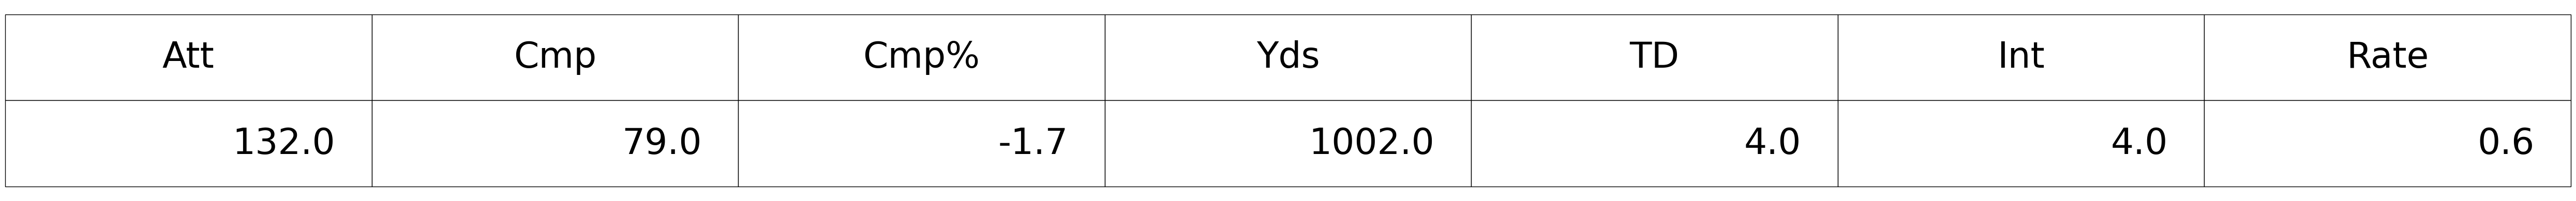

In [660]:
# Create table of average stats loss

df = pd.DataFrame([avgLoss23])

# Plotting a table using Matplotlib
fig, ax = plt.subplots()
ax.axis('off')  # Hide the axis

# Create the table from DataFrame
table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')

table.scale(10, 10)  # Increase both width and height of the table by 1.5 times

# Increase font size of the table
table.auto_set_font_size(False)
table.set_fontsize(50)  # Set font size to 14

plt.show()

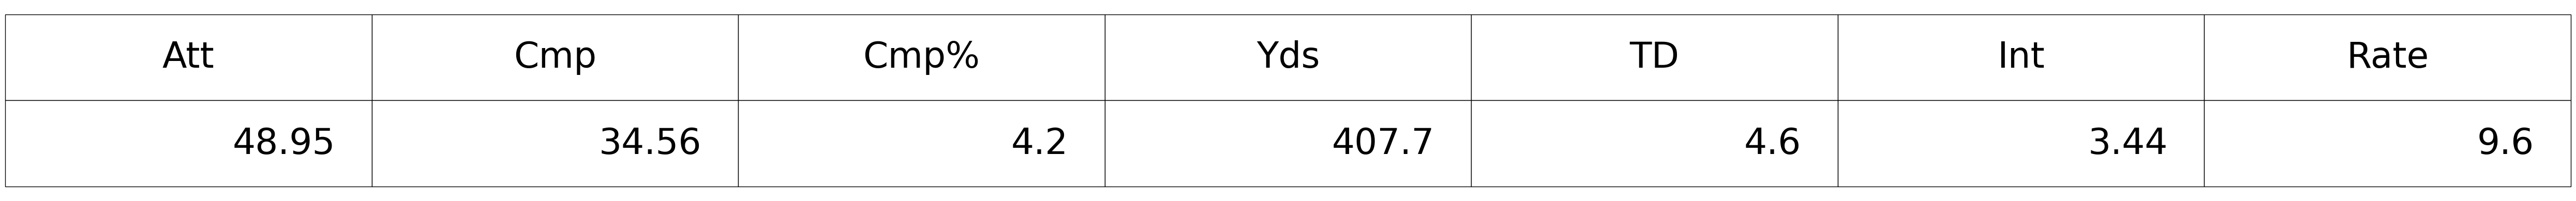

In [661]:
# Create table of average stats loss std dev

df = pd.DataFrame([avgLossStdDev23])

# Plotting a table using Matplotlib
fig, ax = plt.subplots()
ax.axis('off')  # Hide the axis

# Create the table from DataFrame
table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')

table.scale(10, 10)  # Increase both width and height of the table by 1.5 times

# Increase font size of the table
table.auto_set_font_size(False)
table.set_fontsize(50)  # Set font size to 14

plt.show()

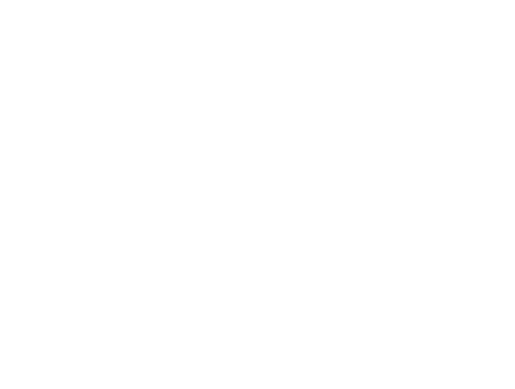

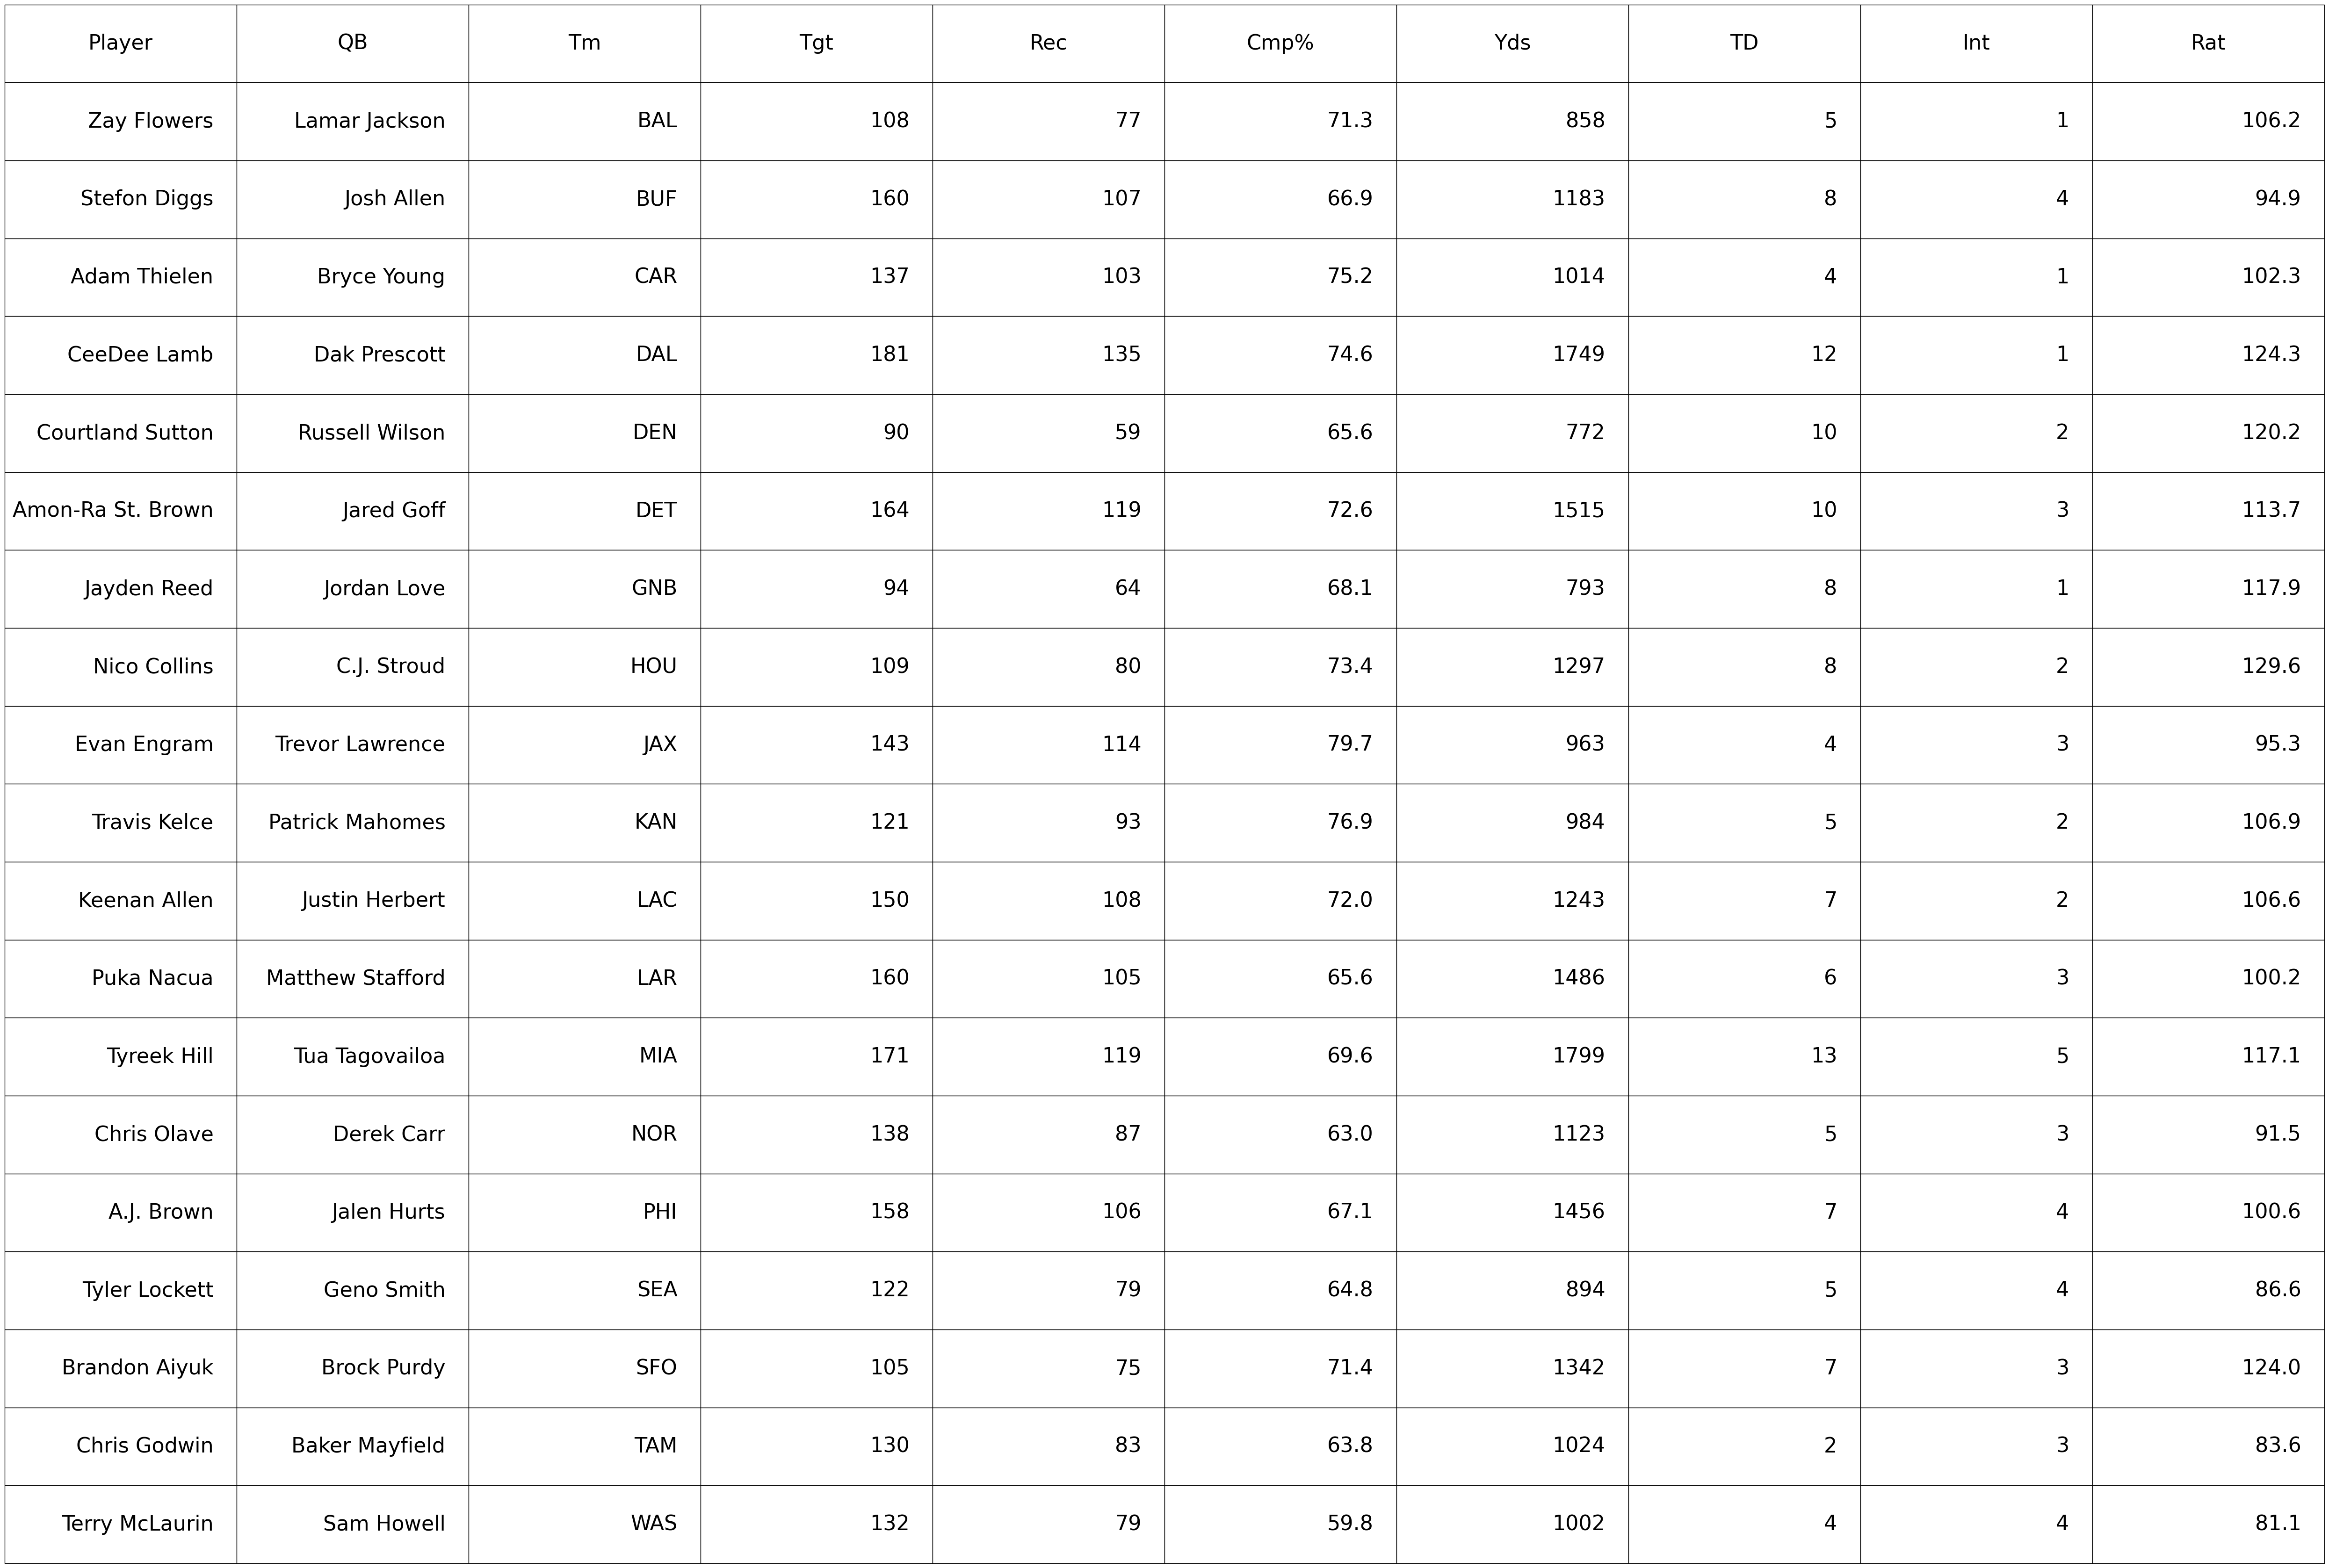

In [662]:
# Create table of advRec stats with corresponding QB

# Plotting a table using Matplotlib
fig, ax = plt.subplots()
ax.axis('off')  # Hide the axis

# Specify which features (columns) to include in the table
features_to_include = ['Player', 'QB', 'Tm', 'Tgt', 'Rec', 'Cmp%', 'Yds', 'TD', 'Int', 'Rat']

# Plotting a table using Matplotlib with specific features
fig, ax = plt.subplots()
ax.axis('off')  # Hide the axis

# Create the table with specific columns from DataFrame
table_data = dfRec23_shared[features_to_include].values
table_columns = features_to_include
table = ax.table(cellText=table_data, colLabels=table_columns, loc='center')

table.scale(10, 10)  # Increase both width and height of the table by 10 times

# Increase font size of the table
table.auto_set_font_size(False)
table.set_fontsize(32)  # Set font size to 14

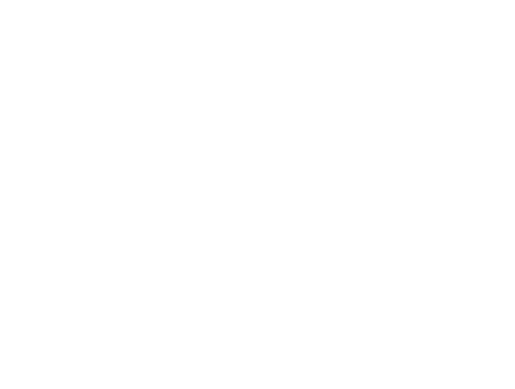

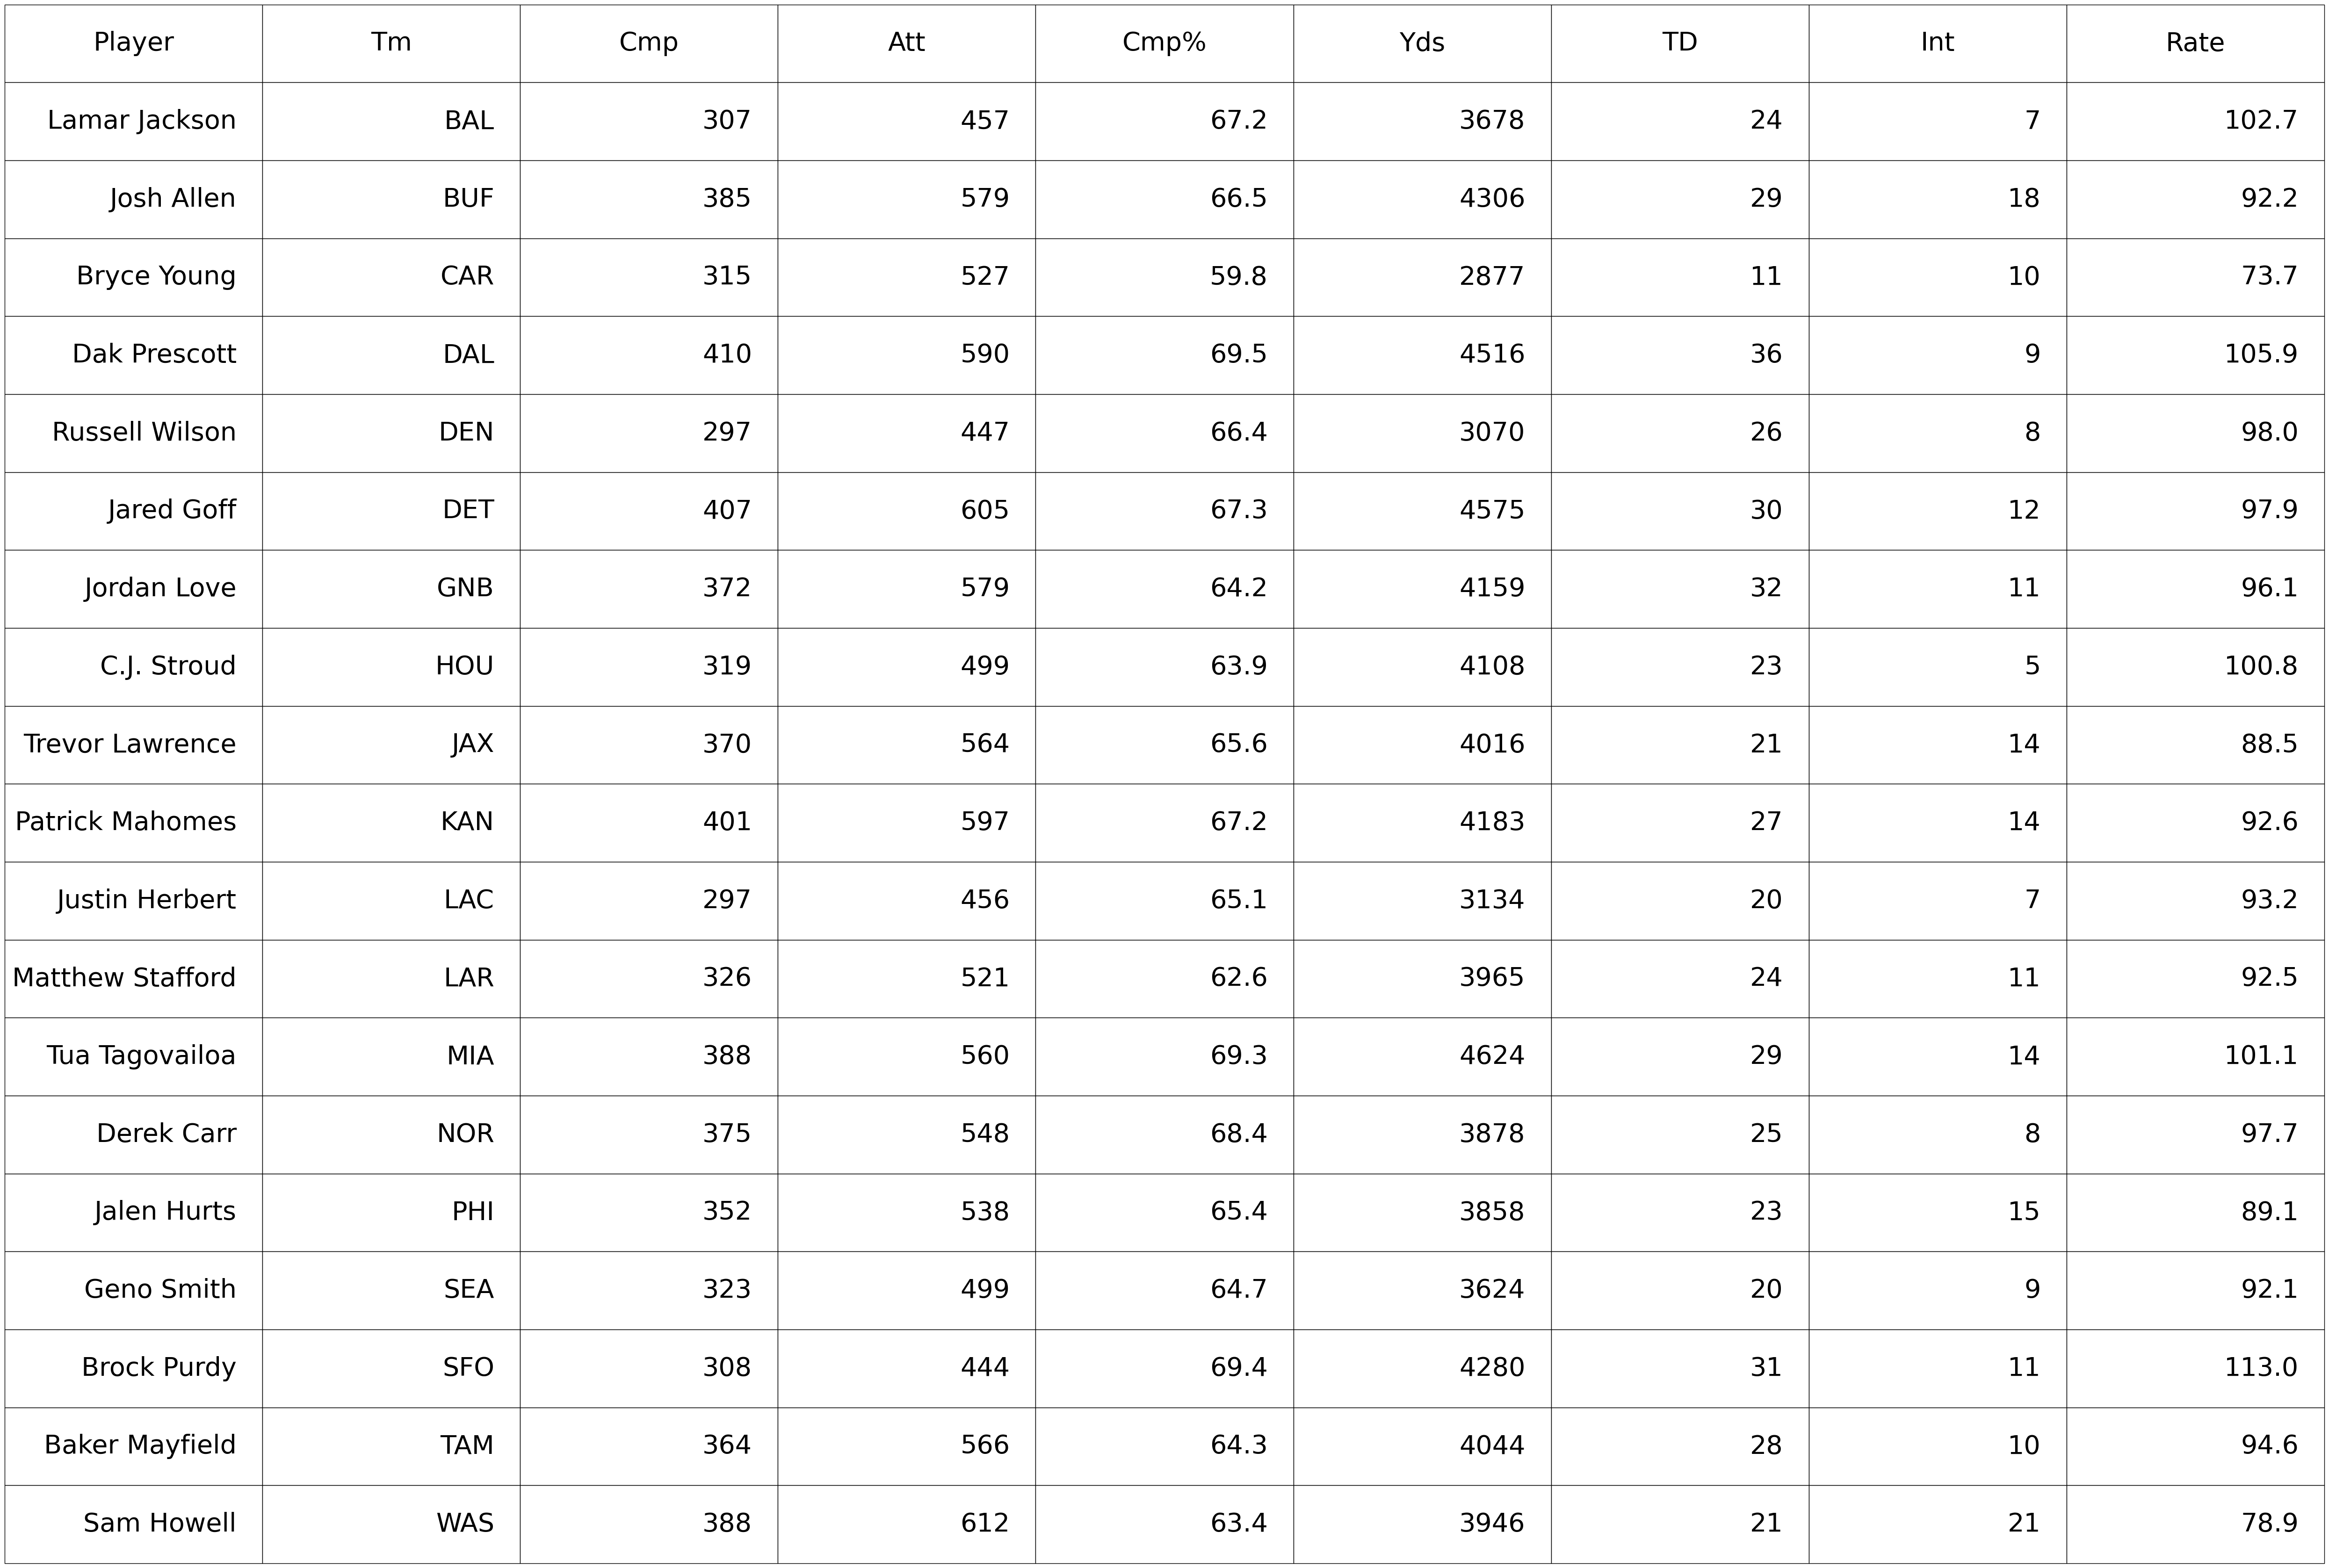

In [657]:
# Create table of qualified QBs stats 

# Plotting a table using Matplotlib
fig, ax = plt.subplots()
ax.axis('off')  # Hide the axis

# Specify which features (columns) to include in the table
features_to_include = ['Player', 'Tm', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Rate']

# Plotting a table using Matplotlib with specific features
fig, ax = plt.subplots()
ax.axis('off')  # Hide the axis

df_graph = dfQB23.sort_values(['Tm'])

# Create the table with specific columns from DataFrame
table_data = df_graph[features_to_include].values
table_columns = features_to_include
table = ax.table(cellText=table_data, colLabels=table_columns, loc='center')

table.scale(10, 10)  # Increase both width and height of the table by 10 times

# Increase font size of the table
table.auto_set_font_size(False)
table.set_fontsize(40)  # Set font size to 14

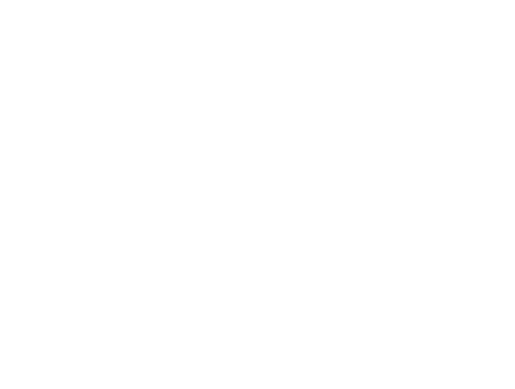

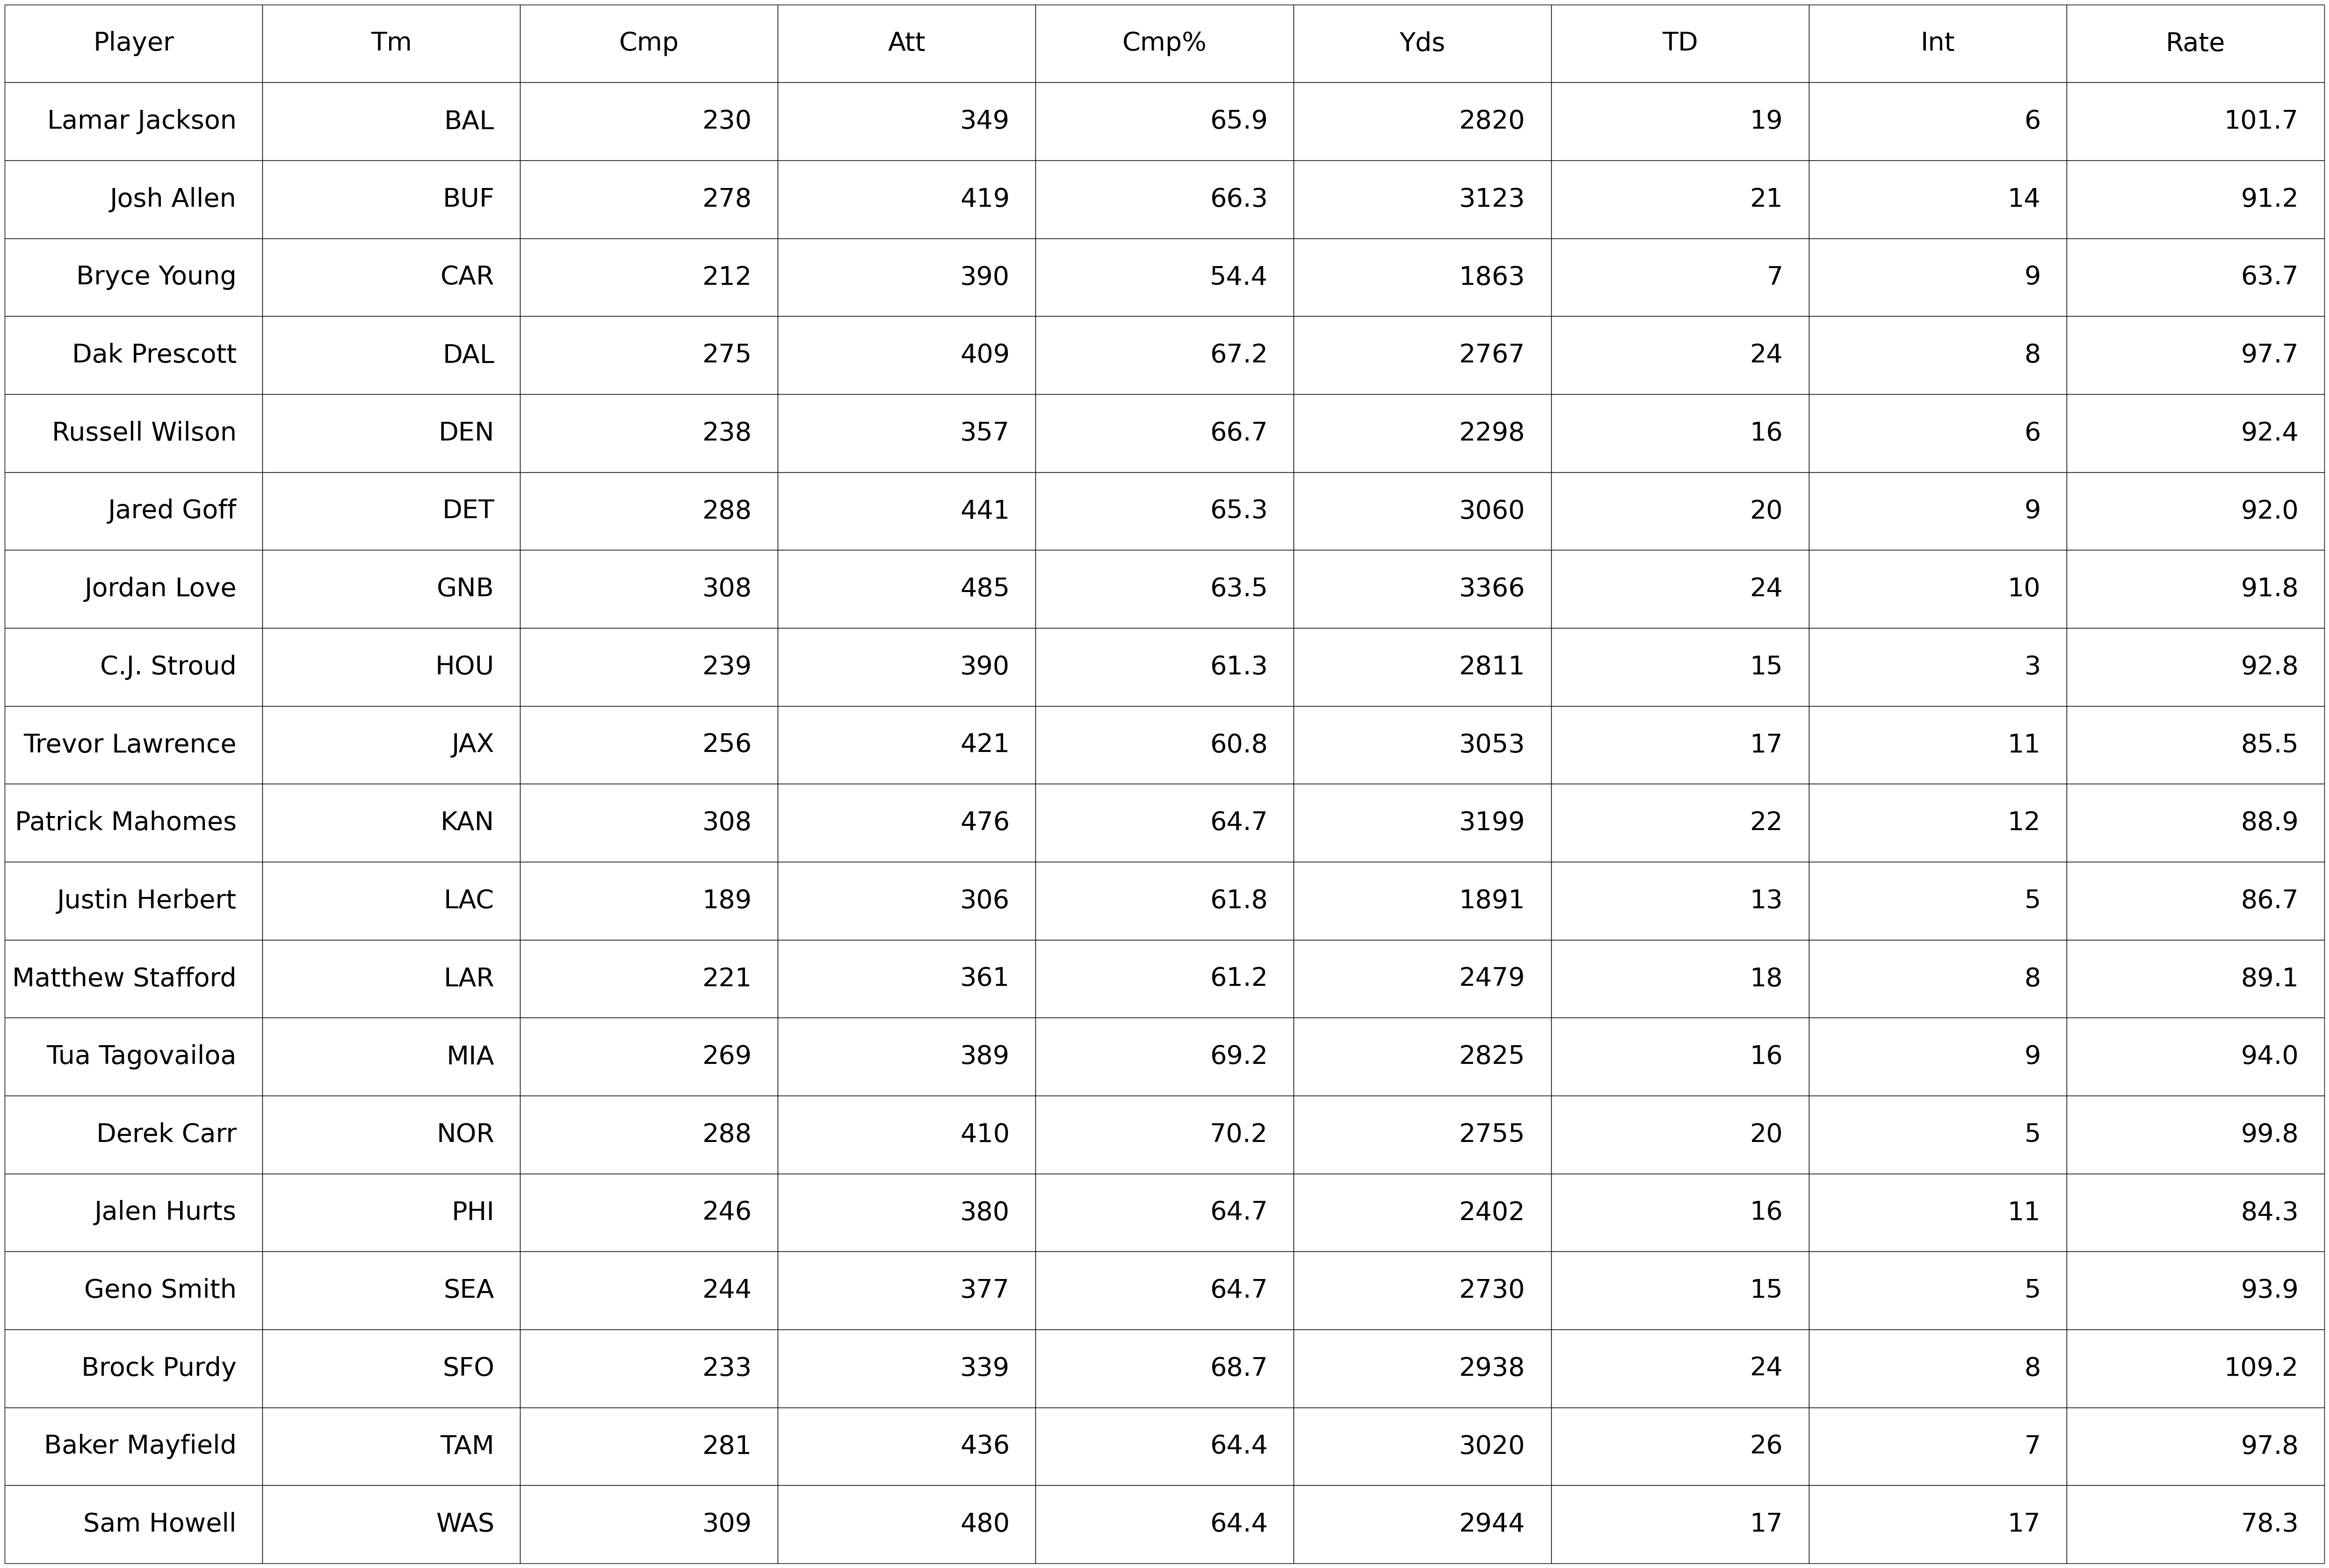

In [663]:
# Create table of qualified QBs stats after loss

# Plotting a table using Matplotlib
fig, ax = plt.subplots()
ax.axis('off')  # Hide the axis

# Specify which features (columns) to include in the table
features_to_include = ['Player', 'Tm', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Rate']

# Plotting a table using Matplotlib with specific features
fig, ax = plt.subplots()
ax.axis('off')  # Hide the axis

df_graph = dfQB23_sub.sort_values(['Tm'])

# Create the table with specific columns from DataFrame
table_data = df_graph[features_to_include].values
table_columns = features_to_include
table = ax.table(cellText=table_data, colLabels=table_columns, loc='center')

table.scale(10, 10)  # Increase both width and height of the table by 10 times

# Increase font size of the table
table.auto_set_font_size(False)
table.set_fontsize(40)  # Set font size to 14

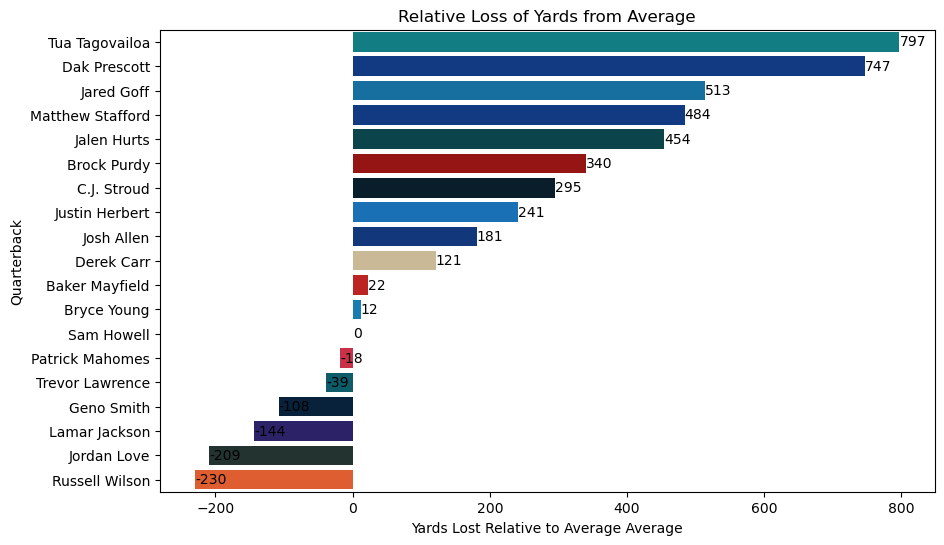

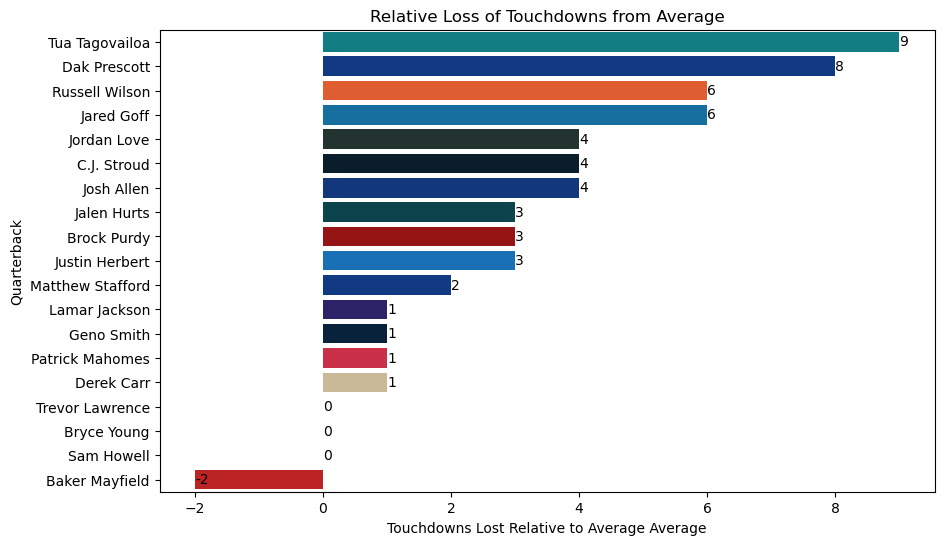

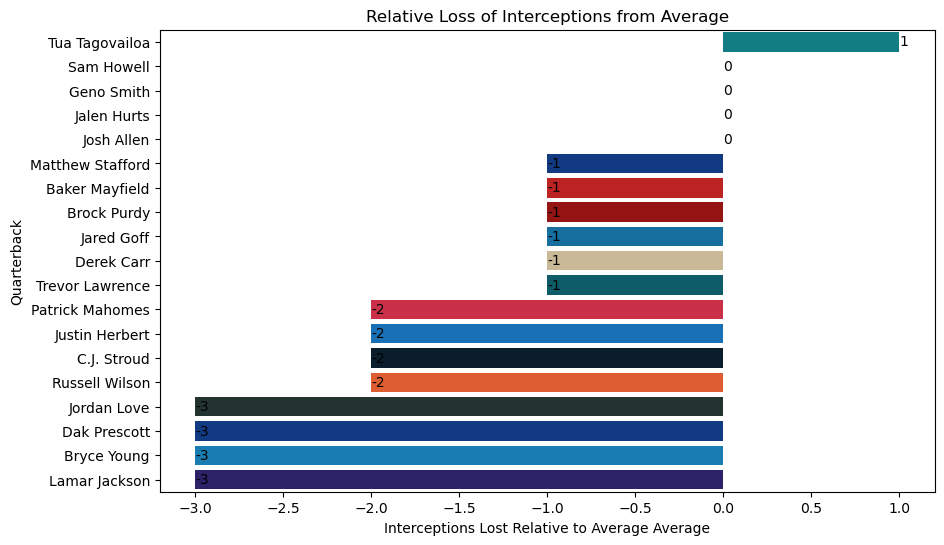

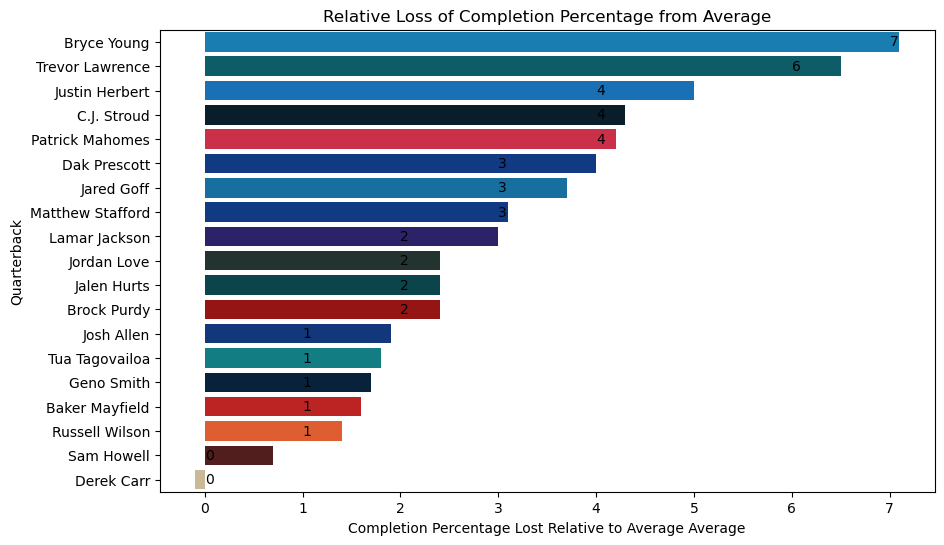

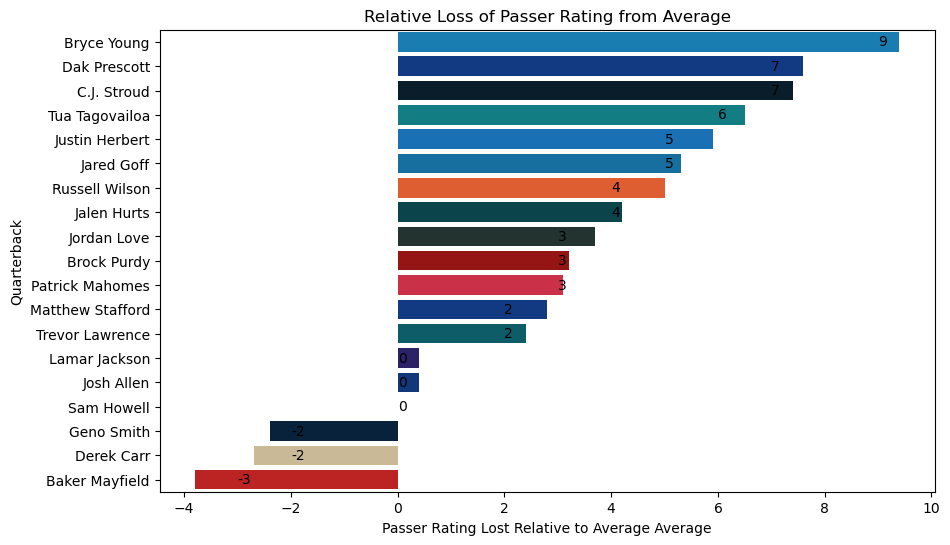

In [620]:
ydsPlot = statGrapher(df_QBrel23, 'Yds', 'Yards')

tdPlot = statGrapher(df_QBrel23, 'TD', 'Touchdowns')

intPlot = statGrapher(df_QBrel23, 'Int', 'Interceptions')

cmpPerPlot = statGrapher(df_QBrel23, 'Cmp%', 'Completion Percentage')

psrRtgPlot = statGrapher(df_QBrel23, 'Rate', 'Passer Rating')

In [575]:
# Testing cell
'''
for x in yds_ranked:
    print(x)
print(yds_ranked.index)
print(yds_ranked.shape[0])
print(yds_ranked.astype(int))
'''

print(advTopRec[23].head())
dfRec23 = advTopRec[23].copy(deep=True)
print(dfRec23)

    Tm  Rec               Player  Age Pos  Tgt   Yds  TD  Int    Rat
0  DAL  135        CeeDee Lamb*+   24  WR  181  1749  12    1  124.3
1  MIA  119        Tyreek Hill*+   29  WR  171  1799  13    5  117.1
2  DET  119  Amon-Ra St. Brown*+   24  WR  164  1515  10    3  113.7
3  JAX  114         Evan Engram*   29  TE  143   963   4    3   95.3
4  IND  109  Michael Pittman Jr.   26  WR  156  1152   4    6   83.6
     Tm  Rec               Player  Age Pos  Tgt   Yds  TD  Int    Rat
0   DAL  135        CeeDee Lamb*+   24  WR  181  1749  12    1  124.3
1   MIA  119        Tyreek Hill*+   29  WR  171  1799  13    5  117.1
2   DET  119  Amon-Ra St. Brown*+   24  WR  164  1515  10    3  113.7
3   JAX  114         Evan Engram*   29  TE  143   963   4    3   95.3
4   IND  109  Michael Pittman Jr.   26  WR  156  1152   4    6   83.6
5   LAC  108        Keenan Allen*   31  WR  150  1243   7    2  106.6
6   BUF  107        Stefon Diggs*   30  WR  160  1183   8    4   94.9
7   PHI  106          A.J.